In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numba import *
import math
from SEIAR_Discrete import SEIR_model
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Read data files
central = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'Central Region (2)')
east = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'East Region')
north_central = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'North Central')
north_coastal = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'North Costal')
north_inland = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'North Inland')
south = pd.read_excel('/Users/kazi0302/Desktop/SDSU/MSCSDS/COVID-19-Modeling-and-Parameter-Fitting/Data/Data-Processed-Date/Regions-By-Date.xlsx', header = None, sheet_name = 'South Region')

# Set headers
central.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date', 'Diff Raw', 'Diff', 'temp1', 'temp2']
east.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date']
north_central.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date']
north_coastal.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date']
north_inland.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date']
south.columns = ['Case Count (Raw)', 'Total Rate (Suppressed)', 'Date']

# Transform data to datetime format
central['Date'] = pd.to_datetime(central['Date'])
east['Date'] = pd.to_datetime(east['Date'])
north_central['Date'] = pd.to_datetime(north_central['Date'])
north_coastal['Date'] = pd.to_datetime(north_coastal['Date'])
north_inland['Date'] = pd.to_datetime(north_inland['Date'])
south['Date'] = pd.to_datetime(south['Date'])

In [3]:
# Count daily cases
central_daily_total = (central['Total Rate (Suppressed)'].diff()).dropna()
central_daily_raw = (central['Case Count (Raw)'].diff()).dropna()
east_daily_total = (east['Total Rate (Suppressed)'].diff()).dropna()
east_daily_raw = (east['Case Count (Raw)'].diff()).dropna()
north_central_daily_total = (north_central['Total Rate (Suppressed)'].diff()).dropna()
north_central_daily_raw = (north_central['Case Count (Raw)'].diff()).dropna()
north_coastal_daily_total = (north_coastal['Total Rate (Suppressed)'].diff()).dropna()
north_coastal_daily_raw = (north_coastal['Case Count (Raw)'].diff()).dropna()
north_inland_daily_total = (north_inland['Total Rate (Suppressed)'].diff()).dropna()
north_inland_daily_raw = (north_inland['Case Count (Raw)'].diff()).dropna()
south_daily_total = (south['Total Rate (Suppressed)'].diff()).dropna()
south_daily_raw = (south['Case Count (Raw)'].diff()).dropna()

In [4]:
# Susceptible, Exposed, Infected_Symptomatic, Infected_Asymptomatic, Recovered
init_pop = {
    'Central_High': [234144, 1, 1, 1, 0],
    'Central_Low': [277516, 0, 0, 0, 0],
    'East_High': [249102, 0, 0, 0, 0],
    'East_Low': [239228, 0, 0, 0, 0],
    'North_Central_High': [175301, 0, 0, 0, 0],
    'North_Central_Low': [471079, 0, 0, 0, 0],
    'North_Coastal_High': [159507, 0, 0, 0, 0],
    'North_Coastal_Low': [375712, 0, 0, 0, 0],
    'North_Inland_High': [195235, 0, 0, 0, 0],
    'North_Inland_Low': [406765, 0, 0, 0, 0],
    'South_High': [212538, 0, 0, 0, 0],
    'South_Low': [287538, 0, 0, 0, 0]
}

In [5]:
max_mobility = 1.426903937910839
min_mobility = 0.01439781153264704
avg_mobility = 0.3120317933159559

In [6]:
# Central High Risk
S_H_C, E_H_C, I_H_C, A_H_C, R_H_C = init_pop['Central_High'][0],\
                                    init_pop['Central_High'][1],\
                                    init_pop['Central_High'][2],\
                                    init_pop['Central_High'][3],\
                                    init_pop['Central_High'][4]

# Central Low Risk
S_L_C, E_L_C, I_L_C, A_L_C, R_L_C = init_pop['Central_Low'][0],\
                                    init_pop['Central_Low'][1],\
                                    init_pop['Central_Low'][2],\
                                    init_pop['Central_Low'][3],\
                                    init_pop['Central_Low'][4]

# East High Risk
S_H_E, E_H_E, I_H_E, A_H_E, R_H_E = init_pop['East_High'][0],\
                                    init_pop['East_High'][1],\
                                    init_pop['East_High'][2],\
                                    init_pop['East_High'][3],\
                                    init_pop['East_High'][4]

# East Low Risk
S_L_E, E_L_E, I_L_E, A_L_E, R_L_E = init_pop['East_Low'][0],\
                                    init_pop['East_Low'][1],\
                                    init_pop['East_Low'][2],\
                                    init_pop['East_Low'][3],\
                                    init_pop['East_Low'][4]

# North Central High Risk
S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen = init_pop['North_Central_High'][0],\
                                                   init_pop['North_Central_High'][1],\
                                                   init_pop['North_Central_High'][2],\
                                                   init_pop['North_Central_High'][3],\
                                                   init_pop['North_Central_High'][4]

# North Central Low Risk
S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen =  init_pop['North_Central_Low'][0],\
                                                    init_pop['North_Central_Low'][1],\
                                                    init_pop['North_Central_Low'][2],\
                                                    init_pop['North_Central_Low'][3],\
                                                    init_pop['North_Central_Low'][4]

# North Coastal High Risk
S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa =  init_pop['North_Coastal_High'][0],\
                                                    init_pop['North_Coastal_High'][1],\
                                                    init_pop['North_Coastal_High'][2],\
                                                    init_pop['North_Coastal_High'][3],\
                                                    init_pop['North_Coastal_High'][4]

# North Coastal Low Risk
S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa =  init_pop['North_Coastal_Low'][0],\
                                                    init_pop['North_Coastal_Low'][1],\
                                                    init_pop['North_Coastal_Low'][2],\
                                                    init_pop['North_Coastal_Low'][3],\
                                                    init_pop['North_Coastal_Low'][4]

# North Inland High Risk
S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI =  init_pop['North_Inland_High'][0],\
                                          init_pop['North_Inland_High'][1],\
                                          init_pop['North_Inland_High'][2],\
                                          init_pop['North_Inland_High'][3],\
                                          init_pop['North_Inland_High'][4]

# North Inland Low Risk
S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI =  init_pop['North_Inland_Low'][0],\
                                          init_pop['North_Inland_Low'][1],\
                                          init_pop['North_Inland_Low'][2],\
                                          init_pop['North_Inland_Low'][3],\
                                          init_pop['North_Inland_Low'][4]

# South High Risk
S_H_S, E_H_S, I_H_S, A_H_S, R_H_S = init_pop['South_High'][0],\
                                    init_pop['South_High'][1],\
                                    init_pop['South_High'][2],\
                                    init_pop['South_High'][3],\
                                    init_pop['South_High'][4]

# South Low Risk
S_L_S, E_L_S, I_L_S, A_L_S, R_L_S = init_pop['South_Low'][0],\
                                    init_pop['South_Low'][1],\
                                    init_pop['South_Low'][2],\
                                    init_pop['South_Low'][3],\
                                    init_pop['South_Low'][4]

In [7]:
param_dict = {
    'High': [0.4e-6, 0.2e-6, 1/5, 0.4, 1/14, 0.001],
    'Low': [0.4e-6, 0.2e-6, 1/5, 0.4, 1/14, 0.001],
}

# beta_symp = param_dict['High'][0]
# beta_asym = param_dict['High'][1]
gamma = param_dict['High'][2]
theta = param_dict['High'][3]
lamb = param_dict['High'][4]
delta = param_dict['High'][5]

In [8]:
@jit(nopython=True, parallel=True)
def SEIAR_model(S_H_C, E_H_C, I_H_C, A_H_C, R_H_C, S_L_C, E_L_C, I_L_C, A_L_C, R_L_C,\
               S_H_E, E_H_E, I_H_E, A_H_E, R_H_E, S_L_E, E_L_E, I_L_E, A_L_E, R_L_E,\
               S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen, S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen,\
               S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa, S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa,\
               S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI, S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI,\
               S_H_S, E_H_S, I_H_S, A_H_S, R_H_S, S_L_S, E_L_S, I_L_S, A_L_S, R_L_S, \
               beta_sym, beta_asym, gamma, theta, lamb, delta, mob_central, mob_east, mob_north_central, mob_north_coastal, mob_north_inland, mob_south):
   
    t = 213
    
    C_H = np.zeros((t+1, 5))
    C_L = np.zeros((t+1, 5))

    E_H = np.zeros((t+1, 5))
    E_L = np.zeros((t+1, 5))

    NCen_H = np.zeros((t+1, 5))
    NCen_L = np.zeros((t+1, 5))

    NCoa_H = np.zeros((t+1, 5))
    NCoa_L = np.zeros((t+1, 5))

    NI_H = np.zeros((t+1, 5))
    NI_L = np.zeros((t+1, 5))

    S_H = np.zeros((t+1, 5))
    S_L = np.zeros((t+1, 5))

    for day in range(t):

        # Generate mean SEIAR

        Central_High = { 'S_to_E': np.random.binomial(S_H_C, (beta_sym * I_H_C) + (beta_asym * A_H_C)),
                         'E_to_I': np.random.binomial(E_H_C, gamma*theta),
                         'E_to_A': np.random.binomial(E_H_C, gamma*(1-theta)),
                         'I_to_R': np.random.binomial(I_H_C, delta + lamb),
                         'A_to_R': np.random.binomial(A_H_C, delta) }

        Central_Low = { 'S_to_E': np.random.binomial(S_L_C, (beta_sym * I_L_C) + (beta_asym * A_L_C)),
                        'E_to_I': np.random.binomial(E_L_C, gamma*theta),
                        'E_to_A': np.random.binomial(E_L_C, gamma*(1-theta)),
                        'I_to_R': np.random.binomial(I_L_C, delta + lamb),
                        'A_to_R': np.random.binomial(A_L_C, delta) }

        East_High = { 'S_to_E': np.random.binomial(S_H_E, (beta_sym * I_H_E) + (beta_asym * A_H_E)),
                      'E_to_I': np.random.binomial(E_H_E, gamma*theta),
                      'E_to_A': np.random.binomial(E_H_E, gamma*(1-theta)),
                      'I_to_R': np.random.binomial(I_H_E, delta + lamb),
                      'A_to_R': np.random.binomial(A_H_E, delta) }

        East_Low = {    'S_to_E': np.random.binomial(S_L_E, (beta_sym * I_L_E) + (beta_asym * A_L_E)),
                        'E_to_I': np.random.binomial(E_L_E, gamma*theta),
                        'E_to_A': np.random.binomial(E_L_E, gamma*(1-theta)),
                        'I_to_R': np.random.binomial(I_L_E, delta + lamb),
                        'A_to_R': np.random.binomial(A_L_E, delta) }
        
        North_Central_High = {  'S_to_E': np.random.binomial(S_H_NCen, (beta_sym * I_H_NCen) + (beta_asym * A_H_NCen)),
                                'E_to_I': np.random.binomial(E_H_NCen, gamma*theta),
                                'E_to_A': np.random.binomial(E_H_NCen, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_H_NCen, delta + lamb),
                                'A_to_R': np.random.binomial(A_H_NCen, delta) }
        
        North_Central_Low = {   'S_to_E': np.random.binomial(S_L_NCen, (beta_sym * I_L_NCen) + (beta_asym * A_L_NCen)),
                                'E_to_I': np.random.binomial(E_L_NCen, gamma*theta),
                                'E_to_A': np.random.binomial(E_L_NCen, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_L_NCen, delta + lamb),
                                'A_to_R': np.random.binomial(A_L_NCen, delta) }

        North_Coastal_High = {  'S_to_E': np.random.binomial(S_H_NCoa, (beta_sym * I_H_NCoa) + (beta_asym * A_H_NCoa)),
                                'E_to_I': np.random.binomial(E_H_NCoa, gamma*theta),
                                'E_to_A': np.random.binomial(E_H_NCoa, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_H_NCoa, delta + lamb),
                                'A_to_R': np.random.binomial(A_H_NCoa, delta) }
        
        North_Coastal_Low = {   'S_to_E': np.random.binomial(S_L_NCoa, (beta_sym * I_L_NCoa) + (beta_asym * A_L_NCoa)),
                                'E_to_I': np.random.binomial(E_L_NCoa, gamma*theta),
                                'E_to_A': np.random.binomial(E_L_NCoa, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_L_NCoa, delta + lamb),
                                'A_to_R': np.random.binomial(A_L_NCoa, delta) }
        
        North_Inland_High = {   'S_to_E': np.random.binomial(S_H_NI, (beta_sym * I_H_NI) + (beta_asym * A_H_NI)),
                                'E_to_I': np.random.binomial(E_H_NI, gamma*theta),
                                'E_to_A': np.random.binomial(E_H_NI, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_H_NI, delta + lamb),
                                'A_to_R': np.random.binomial(A_H_NI, delta) }

        North_Inland_Low = {    'S_to_E': np.random.binomial(S_L_NI, (beta_sym * I_L_NI) + (beta_asym * A_L_NI)),
                                'E_to_I': np.random.binomial(E_L_NI, gamma*theta),
                                'E_to_A': np.random.binomial(E_L_NI, gamma*(1-theta)),
                                'I_to_R': np.random.binomial(I_L_NI, delta + lamb),
                                'A_to_R': np.random.binomial(A_L_NI, delta) }
        
        South_High = {  'S_to_E': np.random.binomial(S_H_S, (beta_sym * I_H_S) + (beta_asym * A_H_S)),
                        'E_to_I': np.random.binomial(E_H_S, gamma*theta),
                        'E_to_A': np.random.binomial(E_H_S, gamma*(1-theta)),
                        'I_to_R': np.random.binomial(I_H_S, delta + lamb),
                        'A_to_R': np.random.binomial(A_H_S, delta) }

        South_Low = {   'S_to_E': np.random.binomial(S_L_S, (beta_sym * I_L_S) + (beta_asym * A_L_S)),
                        'E_to_I': np.random.binomial(E_L_S, gamma*theta),
                        'E_to_A': np.random.binomial(E_L_S, gamma*(1-theta)),
                        'I_to_R': np.random.binomial(I_L_S, delta + lamb),
                        'A_to_R': np.random.binomial(A_L_S, delta) }
                                
        # Compute new SEIAR
        Central_High_S_new = max(S_H_C - Central_High['S_to_E'] + \
            mob_central*(S_H_E + S_H_NCen + S_H_NCoa + S_H_NI + S_H_S) - 5 * mob_central * S_H_C, 0)
        Central_High_E_new = max(E_H_C + Central_High['S_to_E'] - Central_High['E_to_I'] - Central_High['E_to_A'] + \
            mob_central*(E_H_E + E_H_NCen + E_H_NCoa + E_H_NI + E_H_S) - 5 * mob_central * E_H_C, 0)
        Central_High_I_new = max(I_H_C + Central_High['E_to_I'] - Central_High['I_to_R'] + \
            mob_central*(I_H_E + I_H_NCen + I_H_NCoa + I_H_NI + I_H_S) - 5 * mob_central * I_H_C, 0)
        Central_High_A_new = max(A_H_C + Central_High['E_to_A'] - Central_High['A_to_R'] + \
            mob_central*(A_H_E + A_H_NCen + A_H_NCoa + A_H_NI + A_H_S) - 5 * mob_central * A_H_C, 0)
        Central_High_R_new = max(R_H_C + Central_High['I_to_R'] + Central_High['A_to_R'] + \
            mob_central*(R_H_E + R_H_NCen + R_H_NCoa + R_H_NI + R_H_S) - 5 * mob_central * R_H_C, 0)

        Central_Low_S_new = max(S_L_C - Central_Low['S_to_E'] + \
            mob_central*(S_L_E + S_L_NCen + S_L_NCoa + S_L_NI + S_H_S) - 5 * mob_central * S_L_C, 0)
        Central_Low_E_new = max(E_L_C + Central_Low['S_to_E'] - Central_Low['E_to_I'] - Central_Low['E_to_A'] + \
            mob_central*(E_L_E + E_L_NCen + E_L_NCoa + E_L_NI + E_L_S) - 5 * mob_central * E_L_C, 0)
        Central_Low_I_new = max(I_L_C + Central_Low['E_to_I'] - Central_Low['I_to_R'] + \
            mob_central*(I_L_E + I_L_NCen + I_L_NCoa + I_L_NI + I_L_S) - 5 * mob_central * I_L_C, 0)
        Central_Low_A_new = max(A_L_C + Central_Low['E_to_A'] - Central_Low['A_to_R'] + \
            mob_central*(A_L_E + A_L_NCen + A_L_NCoa + A_L_NI + A_L_S) - 5 * mob_central * A_L_C, 0)
        Central_Low_R_new = max(R_L_C + Central_Low['I_to_R'] + Central_Low['A_to_R'] + \
            mob_central*(R_L_E + R_L_NCen + R_L_NCoa + R_L_NI + R_L_S) - 5 * mob_central * R_L_C, 0)
        
        East_High_S_new = max(S_H_E - East_High['S_to_E'] + \
            mob_east*(S_H_C + S_H_NCen + S_H_NCoa + S_H_NI + S_H_S) - 5 * mob_east * S_H_E, 0)
        East_High_E_new = max(E_H_E + East_High['S_to_E'] - East_High['E_to_I'] - East_High['E_to_A'] + \
            mob_east*(E_H_C + E_H_NCen + E_H_NCoa + E_H_NI + E_H_S) - 5 * mob_east * E_H_E, 0)
        East_High_I_new = max(I_H_E + East_High['E_to_I'] - East_High['I_to_R'] + \
            mob_east*(I_H_C + I_H_NCen + I_H_NCoa + I_H_NI + I_H_S) - 5 * mob_east * I_H_E, 0)
        East_High_A_new = max(A_H_E + East_High['E_to_A'] - East_High['A_to_R'] + \
            mob_east*(A_H_C + A_H_NCen + A_H_NCoa + A_H_NI + A_H_S) - 5 * mob_east * A_H_E, 0)
        East_High_R_new = max(R_H_E + East_High['I_to_R'] + East_High['A_to_R'] + \
            mob_east*(R_H_C + R_H_NCen + R_H_NCoa + R_H_NI + R_H_S) - 5 * mob_east * R_H_E, 0)

        East_Low_S_new = max(S_L_E - East_Low['S_to_E'] + \
            mob_east*(S_L_C + S_L_NCen + S_L_NCoa + S_L_NI + S_L_S) - 5 * mob_east * S_L_E, 0)
        East_Low_E_new = max(E_L_E + East_Low['S_to_E'] - East_Low['E_to_I'] - East_Low['E_to_A'] + \
            mob_east*(E_L_C + E_L_NCen + E_L_NCoa + E_L_NI + E_L_S) - 5 * mob_east * E_L_E, 0)
        East_Low_I_new = max(I_L_E + East_Low['E_to_I'] - East_Low['I_to_R'] + \
            mob_east*(I_L_C + I_L_NCen + I_L_NCoa + I_L_NI + I_L_S) - 5 * mob_east * I_L_E, 0)
        East_Low_A_new = max(A_L_E + East_Low['E_to_A'] - East_Low['A_to_R'] + \
            mob_east*(A_L_C + A_L_NCen + A_L_NCoa + A_L_NI + A_L_S) - 5 * mob_east * A_L_E, 0)
        East_Low_R_new = max(R_L_E + East_Low['I_to_R'] + East_Low['A_to_R'] + \
            mob_east*(R_L_C + R_L_NCen + R_L_NCoa + R_L_NI + R_L_S) - 5 * mob_east * R_L_E, 0)
        
        North_Central_High_S_new = max(S_H_NCen - North_Central_High['S_to_E'] + \
            mob_north_central*(S_H_C + S_H_E + S_H_NCoa + S_H_NI + S_H_S) - 5 * mob_north_central * S_H_NCen, 0)
        North_Central_High_E_new = max(E_H_NCen + North_Central_High['S_to_E'] - North_Central_High['E_to_I'] - North_Central_High['E_to_A'] + \
            mob_north_central*(E_H_C + E_H_E + E_H_NCoa + E_H_NI + E_H_S) - 5 * mob_north_central * E_H_NCen, 0)
        North_Central_High_I_new = max(I_H_NCen + North_Central_High['E_to_I'] - North_Central_High['I_to_R'] + \
            mob_north_central*(I_H_C + I_H_E + I_H_NCoa + I_H_NI + I_H_S) - 5 * mob_north_central * I_H_NCen, 0)
        North_Central_High_A_new = max(A_H_NCen + North_Central_High['E_to_A'] - North_Central_High['A_to_R'] + \
            mob_north_central*(A_H_C + A_H_E + A_H_NCoa + A_H_NI + A_H_S) - 5 * mob_north_central * A_H_NCen, 0)
        North_Central_High_R_new = max(R_H_NCen + North_Central_High['I_to_R'] + North_Central_High['A_to_R'] + \
            mob_north_central*(R_H_C + R_H_E + R_H_NCoa + R_H_NI + R_H_S) - 5 * mob_north_central * R_H_NCen, 0)

        North_Central_Low_S_new = max(S_L_NCen - North_Central_Low['S_to_E'] + \
            mob_north_central*(S_L_C + S_L_E + S_L_NCoa + S_L_NI + S_L_S) - 5 * mob_north_central * S_L_NCen, 0)
        North_Central_Low_E_new = max(E_L_NCen + North_Central_Low['S_to_E'] - North_Central_Low['E_to_I'] - North_Central_Low['E_to_A'] + \
            mob_north_central*(E_L_C + E_L_E + E_L_NCoa + E_L_NI + E_L_S) - 5 * mob_north_central * E_L_NCen, 0)
        North_Central_Low_I_new = max(I_L_NCen + North_Central_Low['E_to_I'] - North_Central_Low['I_to_R'] + \
            mob_north_central*(I_L_C + I_L_E + I_L_NCoa + I_L_NI + I_L_S) - 5 * mob_north_central * I_L_NCen, 0)
        North_Central_Low_A_new = max(A_L_NCen + North_Central_Low['E_to_A'] - North_Central_Low['A_to_R'] + \
            mob_north_central*(A_L_C + A_L_E + A_L_NCoa + A_L_NI + A_L_S) - 5 * mob_north_central * A_L_NCen, 0)
        North_Central_Low_R_new = max(R_L_NCen + North_Central_Low['I_to_R'] + North_Central_Low['A_to_R'] + \
            mob_north_central*(R_L_C + R_L_E + R_L_NCoa + R_L_NI + R_L_S) - 5 * mob_north_central * R_L_NCen, 0)

        North_Coastal_High_S_new = max(S_H_NCoa - North_Coastal_High['S_to_E'] + \
            mob_north_coastal*(S_H_C + S_H_E + S_H_NCen + S_H_NI + S_H_S) - 5 * mob_north_coastal * S_H_NCoa, 0)
        North_Coastal_High_E_new = max(E_H_NCoa + North_Coastal_High['S_to_E'] - North_Coastal_High['E_to_I'] - North_Coastal_High['E_to_A'] + \
            mob_north_coastal*(E_H_C + E_H_E + E_H_NCen + E_H_NI + E_H_S) - 5 * mob_north_coastal * E_H_NCoa, 0)
        North_Coastal_High_I_new = max(I_H_NCoa + North_Coastal_High['E_to_I'] - North_Coastal_High['I_to_R'] + \
            mob_north_coastal*(I_H_C + I_H_E + I_H_NCen + I_H_NI + I_H_S) - 5 * mob_north_coastal * I_H_NCoa, 0)
        North_Coastal_High_A_new = max(A_H_NCoa + North_Coastal_High['E_to_A'] - North_Coastal_High['A_to_R'] + \
            mob_north_coastal*(A_H_C + A_H_E + A_H_NCen + A_H_NI + A_H_S) - 5 * mob_north_coastal * A_H_NCoa, 0)
        North_Coastal_High_R_new = max(R_H_NCoa + North_Coastal_High['I_to_R'] + North_Coastal_High['A_to_R'] + \
            mob_north_coastal*(R_H_C + R_H_E + R_H_NCen + R_H_NI + R_H_S) - 5 * mob_north_coastal * R_H_NCoa, 0)

        North_Coastal_Low_S_new = max(S_L_NCoa - North_Coastal_Low['S_to_E'] + \
            mob_north_coastal*(S_L_C + S_L_E + S_L_NCen + S_L_NI + S_L_S) - 5 * mob_north_coastal * S_L_NCoa, 0)
        North_Coastal_Low_E_new = max(E_L_NCoa + North_Coastal_Low['S_to_E'] - North_Coastal_Low['E_to_I'] - North_Coastal_Low['E_to_A'] + \
            mob_north_coastal*(E_L_C + E_L_E + E_L_NCen + E_L_NI + E_L_S) - 5 * mob_north_coastal * E_L_NCoa, 0)
        North_Coastal_Low_I_new = max(I_L_NCoa + North_Coastal_Low['E_to_I'] - North_Coastal_Low['I_to_R'] + \
            mob_north_coastal*(I_L_C + I_L_E + I_L_NCen + I_L_NI + I_L_S) - 5 * mob_north_coastal * I_L_NCoa, 0)
        North_Coastal_Low_A_new = max(A_L_NCoa + North_Coastal_Low['E_to_A'] - North_Coastal_Low['A_to_R'] + \
            mob_north_coastal*(A_L_C + A_L_E + A_L_NCen + A_L_NI + A_L_S) - 5 * mob_north_coastal * A_L_NCoa, 0)
        North_Coastal_Low_R_new = max(R_L_NCoa + North_Coastal_Low['I_to_R'] + North_Coastal_Low['A_to_R'] + \
            mob_north_coastal*(R_L_C + R_L_E + R_L_NCen + R_L_NI + R_L_S) - 5 * mob_north_coastal * R_L_NCoa, 0)

        North_Inland_High_S_new = max(S_H_NI - North_Inland_High['S_to_E'] + \
            mob_north_inland*(S_H_C + S_H_E + S_H_NCen + S_H_NCoa + S_H_S) - 5 * mob_north_inland * S_H_NI, 0)
        North_Inland_High_E_new = max(E_H_NI + North_Inland_High['S_to_E'] - North_Inland_High['E_to_I'] - North_Inland_High['E_to_A'] + \
            mob_north_inland*(E_H_C + E_H_E + E_H_NCen + E_H_NCoa + E_H_S) - 5 * mob_north_inland * E_H_NI, 0)
        North_Inland_High_I_new = max(I_H_NI + North_Inland_High['E_to_I'] - North_Inland_High['I_to_R'] + \
            mob_north_inland*(I_H_C + I_H_E + I_H_NCen + I_H_NCoa + I_H_S) - 5 * mob_north_inland * I_H_NI, 0)
        North_Inland_High_A_new = max(A_H_NI + North_Inland_High['E_to_A'] - North_Inland_High['A_to_R'] + \
            mob_north_inland*(A_H_C + A_H_E + A_H_NCen + A_H_NCoa + A_H_S) - 5 * mob_north_inland * A_H_NI, 0)
        North_Inland_High_R_new = max(R_H_NI + North_Inland_High['I_to_R'] + North_Inland_High['A_to_R'] + \
            mob_north_inland*(R_H_C + R_H_E + R_H_NCen + R_H_NCoa + R_H_S) - 5 * mob_north_inland * R_H_NI, 0)

        North_Inland_Low_S_new = max(S_L_NI - North_Inland_Low['S_to_E'] + \
            mob_north_inland*(S_L_C + S_L_E + S_L_NCen + S_L_NCoa + S_L_S) - 5 * mob_north_inland * S_L_NI, 0)
        North_Inland_Low_E_new = max(E_L_NI + North_Inland_Low['S_to_E'] - North_Inland_Low['E_to_I'] - North_Inland_Low['E_to_A'] + \
            mob_north_inland*(E_L_C + E_L_E + E_L_NCen + E_L_NCoa + E_L_S) - 5 * mob_north_inland * E_L_NI, 0)
        North_Inland_Low_I_new = max(I_L_NI + North_Inland_Low['E_to_I'] - North_Inland_Low['I_to_R'] + \
            mob_north_inland*(I_L_C + I_L_E + I_L_NCen + I_L_NCoa + I_L_S) - 5 * mob_north_inland * I_L_NI, 0)
        North_Inland_Low_A_new = max(A_L_NI + North_Inland_Low['E_to_A'] - North_Inland_Low['A_to_R'] + \
            mob_north_inland*(A_L_C + A_L_E + A_L_NCen + A_L_NCoa + A_L_S) - 5 * mob_north_inland * A_L_NI, 0)
        North_Inland_Low_R_new = max(R_L_NI + North_Inland_Low['I_to_R'] + North_Inland_Low['A_to_R'] + \
            mob_north_inland*(R_L_C + R_L_E + R_L_NCen + R_L_NCoa + R_L_S) - 5 * mob_north_inland * R_L_NI, 0)

        South_High_S_new = max(S_H_S - South_High['S_to_E'] + \
            mob_south*(S_H_C + S_H_E + S_H_NCen + S_H_NCoa + S_H_NI) - 5 * mob_south * S_H_S, 0)
        South_High_E_new = max(E_H_S + South_High['S_to_E'] - South_High['E_to_I'] - South_High['E_to_A'] + \
            mob_south*(E_H_C + E_H_E + E_H_NCen + E_H_NCoa + E_H_NI) - 5 * mob_south * E_H_S, 0)
        South_High_I_new = max(I_H_S + South_High['E_to_I'] - South_High['I_to_R'] + \
            mob_south*(I_H_C + I_H_E + I_H_NCen + I_H_NCoa + I_H_NI) - 5 * mob_south * I_H_S, 0)
        South_High_A_new = max(A_H_S + South_High['E_to_A'] - South_High['A_to_R'] + \
            mob_south*(A_H_C + A_H_E + A_H_NCen + A_H_NCoa + A_H_NI) - 5 * mob_south * A_H_S, 0)
        South_High_R_new = max(R_H_S + South_High['I_to_R'] + South_High['A_to_R'] + \
            mob_south*(R_H_C + R_H_E + R_H_NCen + R_H_NCoa + R_H_NI) - 5 * mob_south * R_H_S, 0)

        South_Low_S_new = max(S_L_S - South_Low['S_to_E'] + \
            mob_south*(S_L_C + S_L_E + S_L_NCen + S_L_NCoa + S_L_NI) - 5 * mob_south * S_L_S, 0)
        South_Low_E_new = max(E_L_S + South_Low['S_to_E'] - South_Low['E_to_I'] - South_Low['E_to_A'] + \
            mob_south*(E_L_C + E_L_E + E_L_NCen + E_L_NCoa + E_L_NI) - 5 * mob_south * E_L_S, 0)
        South_Low_I_new = max(I_L_S + South_Low['E_to_I'] - South_Low['I_to_R'] + \
            mob_south*(I_L_C + I_L_E + I_L_NCen + I_L_NCoa + I_L_NI) - 5 * mob_south * I_L_S, 0)
        South_Low_A_new = max(A_L_S + South_Low['E_to_A'] - South_Low['A_to_R'] + \
            mob_south*(A_L_C + A_L_E + A_L_NCen + A_L_NCoa + A_L_NI) - 5 * mob_south * A_L_S, 0)
        South_Low_R_new = max(R_L_S + South_Low['I_to_R'] + South_Low['A_to_R'] + \
            mob_south*(R_L_C + R_L_E + R_L_NCen + R_L_NCoa + R_L_NI) - 5 * mob_south * R_L_S, 0)

        C_H[day][0], C_H[day][1], C_H[day][2], C_H[day][3], C_H[day][4] =  S_H_C, E_H_C, I_H_C, A_H_C, R_H_C
        C_L[day][0], C_L[day][1], C_L[day][2], C_L[day][3], C_L[day][4] =  S_L_C, E_L_C, I_L_C, A_L_C, R_L_C

        E_H[day][0], E_H[day][1], E_H[day][2], E_H[day][3], E_H[day][4] =  S_H_E, E_H_E, I_H_E, A_H_E, R_H_E
        E_L[day][0], E_L[day][1], E_L[day][2], E_L[day][3], E_L[day][4] =  S_L_E, E_L_E, I_L_E, A_L_E, R_L_E

        NCen_H[day][0], NCen_H[day][1], NCen_H[day][2], NCen_H[day][3], NCen_H[day][4] =  S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen
        NCen_L[day][0], NCen_L[day][1], NCen_L[day][2], NCen_L[day][3], NCen_L[day][4] =  S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen

        NCoa_H[day][0], NCoa_H[day][1], NCoa_H[day][2], NCoa_H[day][3], NCoa_H[day][4] =  S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa
        NCoa_L[day][0], NCoa_L[day][1], NCoa_L[day][2], NCoa_L[day][3], NCoa_L[day][4] =  S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa

        NI_H[day][0], NI_H[day][1], NI_H[day][2], NI_H[day][3], NI_H[day][4] =  S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI
        NI_L[day][0], NI_L[day][1], NI_L[day][2], NI_L[day][3], NI_L[day][4] =  S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI
        
        S_H[day][0], S_H[day][1], S_H[day][2], S_H[day][3], S_H[day][4] =  S_H_S, E_H_S, I_H_S, A_H_S, R_H_S
        S_L[day][0], S_L[day][1], S_L[day][2], S_L[day][3], S_L[day][4] =  S_L_S, E_L_S, I_L_S, A_L_S, R_L_S

        # Update values
        S_H_C, E_H_C, I_H_C, A_H_C, R_H_C = math.ceil(Central_High_S_new), math.ceil(Central_High_E_new), math.ceil(Central_High_I_new), math.ceil(Central_High_A_new), math.ceil(Central_High_R_new)
        S_L_C, E_L_C, I_L_C, A_L_C, R_L_C = math.ceil(Central_Low_S_new), math.ceil(Central_Low_E_new), math.ceil(Central_Low_I_new), math.ceil(Central_Low_A_new), math.ceil(Central_Low_R_new)

        S_H_E, E_H_E, I_H_E, A_H_E, R_H_E = math.ceil(East_High_S_new), math.ceil(East_High_E_new), math.ceil(East_High_I_new), math.ceil(East_High_A_new), math.ceil(East_High_R_new)
        S_L_E, E_L_E, I_L_E, A_L_E, R_L_E = math.ceil(East_Low_S_new), math.ceil(East_Low_E_new), math.ceil(East_Low_I_new), math.ceil(East_Low_A_new), math.ceil(East_Low_R_new)

        S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen = math.ceil(North_Central_High_S_new), math.ceil(North_Central_High_E_new), math.ceil(North_Central_High_I_new), math.ceil(North_Central_High_A_new), math.ceil(North_Central_High_R_new)
        S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen = math.ceil(North_Central_Low_S_new), math.ceil(North_Central_Low_E_new), math.ceil(North_Central_Low_I_new), math.ceil(North_Central_Low_A_new), math.ceil(North_Central_Low_R_new)

        S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa = math.ceil(North_Coastal_High_S_new), math.ceil(North_Coastal_High_E_new), math.ceil(North_Coastal_High_I_new), math.ceil(North_Coastal_High_A_new), math.ceil(North_Coastal_High_R_new)
        S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa = math.ceil(North_Coastal_Low_S_new), math.ceil(North_Coastal_Low_E_new), math.ceil(North_Coastal_Low_I_new), math.ceil(North_Coastal_Low_A_new), math.ceil(North_Coastal_Low_R_new)

        S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI = math.ceil(North_Inland_High_S_new), math.ceil(North_Inland_High_E_new), math.ceil(North_Inland_High_I_new), math.ceil(North_Inland_High_A_new), math.ceil(North_Inland_High_R_new)
        S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI = math.ceil(North_Inland_Low_S_new), math.ceil(North_Inland_Low_E_new), math.ceil(North_Inland_Low_I_new), math.ceil(North_Inland_Low_A_new), math.ceil(North_Inland_Low_R_new)

        S_H_S, E_H_S, I_H_S, A_H_S, R_H_S = math.ceil(South_High_S_new), math.ceil(South_High_E_new), math.ceil(South_High_I_new), math.ceil(South_High_A_new), math.ceil(South_High_R_new)
        S_L_S, E_L_S, I_L_S, A_L_S, R_L_S = math.ceil(South_Low_S_new), math.ceil(South_Low_E_new), math.ceil(South_Low_I_new), math.ceil(South_Low_A_new), math.ceil(South_Low_R_new)

    return C_H, C_L, E_H, E_L, NCen_H, NCen_L, NCoa_H, NCoa_L, NI_H, NI_L, S_H, S_L


In [9]:
result_Central_High_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_Central_Low_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_East_High_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_East_Low_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Central_High_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Central_Low_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Coastal_High_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Coastal_Low_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Inland_High_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Inland_Low_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_South_High_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_South_Low_v1 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }

result_Central_High_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_Central_Low_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_East_High_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_East_Low_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Central_High_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Central_Low_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Coastal_High_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Coastal_Low_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Inland_High_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_North_Inland_Low_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_South_High_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }
result_South_Low_v2 = { 'Mobility': [], 'Beta Symptomatic': [], 'Beta Asymptomatic': [], 'S': [], 'E': [], 'I': [], 'A': [], 'R': [] }

In [10]:
def MC_SEIAR(low_b, up_b):
    
    for beta_symp in np.arange(low_b, up_b, 0.1e-07):
        for beta_asymp in np.arange(low_b, up_b, 0.1e-07):
            try:

                Central_High, Central_Low, East_High, East_Low, NCen_High, NCen_Low, NCoa_High, NCoa_Low, NI_High, NI_Low, South_High, South_Low = \
                SEIAR_model(S_H_C, E_H_C, I_H_C, A_H_C, R_H_C, S_L_C, E_L_C, I_L_C, A_L_C, R_L_C,\
                            S_H_E, E_H_E, I_H_E, A_H_E, R_H_E, S_L_E, E_L_E, I_L_E, A_L_E, R_L_E,\
                            S_H_NCen, E_H_NCen, I_H_NCen, A_H_NCen, R_H_NCen, S_L_NCen, E_L_NCen, I_L_NCen, A_L_NCen, R_L_NCen,\
                            S_H_NCoa, E_H_NCoa, I_H_NCoa, A_H_NCoa, R_H_NCoa, S_L_NCoa, E_L_NCoa, I_L_NCoa, A_L_NCoa, R_L_NCoa,\
                            S_H_NI, E_H_NI, I_H_NI, A_H_NI, R_H_NI, S_L_NI, E_L_NI, I_L_NI, A_L_NI, R_L_NI,\
                            S_H_S, E_H_S, I_H_S, A_H_S, R_H_S, S_L_S, E_L_S, I_L_S, A_L_S, R_L_S, \
                            beta_symp, beta_asymp, gamma, theta, lamb, delta, avg_mobility, avg_mobility, avg_mobility, avg_mobility, avg_mobility, avg_mobility)

                result_Central_High_v1['Mobility'].append(avg_mobility)
                result_Central_High_v1['Beta Symptomatic'].append(beta_symp)
                result_Central_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_Central_High_v1['S'].append(Central_High[:,0])
                result_Central_High_v1['E'].append(Central_High[:,1])
                result_Central_High_v1['I'].append(Central_High[:,2])
                result_Central_High_v1['A'].append(Central_High[:,3])
                result_Central_High_v1['R'].append(Central_High[:,4])

                result_Central_Low_v1['Mobility'].append(avg_mobility)
                result_Central_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_Central_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_Central_Low_v1['S'].append(Central_Low[:,0])
                result_Central_Low_v1['E'].append(Central_Low[:,1])
                result_Central_Low_v1['I'].append(Central_Low[:,2])
                result_Central_Low_v1['A'].append(Central_Low[:,3])
                result_Central_Low_v1['R'].append(Central_Low[:,4])

                result_East_High_v1['Mobility'].append(avg_mobility)
                result_East_High_v1['Beta Symptomatic'].append(beta_symp)
                result_East_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_East_High_v1['S'].append(East_High[:,0])
                result_East_High_v1['E'].append(East_High[:,1])
                result_East_High_v1['I'].append(East_High[:,2])
                result_East_High_v1['A'].append(East_High[:,3])
                result_East_High_v1['R'].append(East_High[:,4])

                result_East_Low_v1['Mobility'].append(avg_mobility)
                result_East_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_East_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_East_Low_v1['S'].append(East_Low[:,0])
                result_East_Low_v1['E'].append(East_Low[:,1])
                result_East_Low_v1['I'].append(East_Low[:,2])
                result_East_Low_v1['A'].append(East_Low[:,3])
                result_East_Low_v1['R'].append(East_Low[:,4])

                result_North_Central_High_v1['Mobility'].append(avg_mobility)
                result_North_Central_High_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Central_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Central_High_v1['S'].append(NCen_High[:,0])
                result_North_Central_High_v1['E'].append(NCen_High[:,1])
                result_North_Central_High_v1['I'].append(NCen_High[:,2])
                result_North_Central_High_v1['A'].append(NCen_High[:,3])
                result_North_Central_High_v1['R'].append(NCen_High[:,4])

                result_North_Central_Low_v1['Mobility'].append(avg_mobility)
                result_North_Central_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Central_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Central_Low_v1['S'].append(NCen_Low[:,0])
                result_North_Central_Low_v1['E'].append(NCen_Low[:,1])
                result_North_Central_Low_v1['I'].append(NCen_Low[:,2])
                result_North_Central_Low_v1['A'].append(NCen_Low[:,3])
                result_North_Central_Low_v1['R'].append(NCen_Low[:,4])

                result_North_Coastal_High_v1['Mobility'].append(avg_mobility)
                result_North_Coastal_High_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Coastal_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Coastal_High_v1['S'].append(NCoa_High[:,0])
                result_North_Coastal_High_v1['E'].append(NCoa_High[:,1])
                result_North_Coastal_High_v1['I'].append(NCoa_High[:,2])
                result_North_Coastal_High_v1['A'].append(NCoa_High[:,3])
                result_North_Coastal_High_v1['R'].append(NCoa_High[:,4])

                result_North_Coastal_Low_v1['Mobility'].append(avg_mobility)
                result_North_Coastal_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_North_Coastal_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_North_Coastal_Low_v1['S'].append(NCoa_Low[:,0])
                result_North_Coastal_Low_v1['E'].append(NCoa_Low[:,1])
                result_North_Coastal_Low_v1['I'].append(NCoa_Low[:,2])
                result_North_Coastal_Low_v1['A'].append(NCoa_Low[:,3])
                result_North_Coastal_Low_v1['R'].append(NCoa_Low[:,4])

                result_South_High_v1['Mobility'].append(avg_mobility)
                result_South_High_v1['Beta Symptomatic'].append(beta_symp)
                result_South_High_v1['Beta Asymptomatic'].append(beta_asymp)
                result_South_High_v1['S'].append(South_High[:,0])
                result_South_High_v1['E'].append(South_High[:,1])
                result_South_High_v1['I'].append(South_High[:,2])
                result_South_High_v1['A'].append(South_High[:,3])
                result_South_High_v1['R'].append(South_High[:,4])

                result_South_Low_v1['Mobility'].append(avg_mobility)
                result_South_Low_v1['Beta Symptomatic'].append(beta_symp)
                result_South_Low_v1['Beta Asymptomatic'].append(beta_asymp)
                result_South_Low_v1['S'].append(South_Low[:,0])
                result_South_Low_v1['E'].append(South_Low[:,1])
                result_South_Low_v1['I'].append(South_Low[:,2])
                result_South_Low_v1['A'].append(South_Low[:,3])
                result_South_Low_v1['R'].append(South_Low[:,4])
                
            except:
                None


In [11]:
# MC_SEIAR(0.95e-05, 1.0e-04)

In [12]:
MC_SEIAR(0.9e-05, 0.95e-05)

In [13]:
MC_SEIAR(0.5e-05, 0.8e-05)

In [14]:
MC_SEIAR(0.8e-05, 0.9e-05)

In [15]:
MC_SEIAR(1.0e-10, 1.0e-08)

In [16]:
MC_SEIAR(1.0e-08, 1.0e-07)

In [17]:
MC_SEIAR(1.0e-07, 1.0e-06)

In [18]:
MC_SEIAR(1.0e-06, 0.5e-05)

In [19]:
central_high_v1 = pd.DataFrame(result_Central_High_v1)
central_low_v1 = pd.DataFrame(result_Central_Low_v1)
east_high_v1 = pd.DataFrame(result_East_High_v1)
east_low_v1 = pd.DataFrame(result_East_Low_v1)
north_central_high_v1 = pd.DataFrame(result_North_Central_High_v1)
north_central_low_v1 = pd.DataFrame(result_North_Central_Low_v1)
north_coastal_high_v1 = pd.DataFrame(result_North_Coastal_High_v1)
north_coastal_low_v1 = pd.DataFrame(result_North_Coastal_Low_v1)
north_inland_high_v1 = pd.DataFrame(result_North_Inland_High_v1)
north_inland_low_v1 = pd.DataFrame(result_North_Inland_Low_v1)
south_high_v1 = pd.DataFrame(result_South_High_v1)
south_low_v1 = pd.DataFrame(result_South_Low_v1)

# central_high_v2 = pd.DataFrame(result_Central_High_v2)
# central_low_v2 = pd.DataFrame(result_Central_Low_v2)
# east_high_v2 = pd.DataFrame(result_East_High_v2)
# east_low_v2 = pd.DataFrame(result_East_Low_v2)
# north_central_high_v2 = pd.DataFrame(result_North_Central_High_v2)
# north_central_low_v2 = pd.DataFrame(result_North_Central_Low_v2)
# north_coastal_high_v2 = pd.DataFrame(result_North_Coastal_High_v2)
# north_coastal_low_v2 = pd.DataFrame(result_North_Coastal_Low_v2)
# north_inland_high_v2 = pd.DataFrame(result_North_Inland_High_v2)
# north_inland_low_v2 = pd.DataFrame(result_North_Inland_Low_v2)
# south_high_v2 = pd.DataFrame(result_South_High_v2)
# south_low_v2 = pd.DataFrame(result_South_Low_v2)

In [20]:
temp1_v1 = central_high_v1['I'] + central_low_v1['I']
temp2_v1 = east_high_v1['I'] + east_low_v1['I']
temp3_v1 = north_central_high_v1['I'] + north_central_low_v1['I']
temp4_v1 = north_coastal_high_v1['I'] + north_coastal_low_v1['I']
temp5_v1 = north_inland_high_v1['I'] + north_inland_low_v1['I']
temp6_v1 = south_high_v1['I'] + south_low_v1['I']

# temp1_v2 = central_high_v2['I'] + central_low_v2['I']
# temp2_v2 = east_high_v2['I'] + east_low_v2['I']
# temp3_v2 = north_central_high_v2['I'] + north_central_low_v2['I']
# temp4_v2 = north_coastal_high_v2['I'] + north_coastal_low_v2['I']
# temp5_v2 = north_inland_high_v2['I'] + north_inland_low_v2['I']
# temp6_v2 = south_high_v2['I'] + south_low_v2['I']

In [21]:
central_high_v1['I_High + I_Low'] = temp1_v1
east_high_v1['I_High + I_Low'] = temp2_v1
north_central_high_v1['I_High + I_Low'] = temp3_v1
north_coastal_high_v1['I_High + I_Low'] = temp4_v1
north_inland_high_v1['I_High + I_Low'] = temp5_v1
south_high_v1['I_High + I_Low'] = temp6_v1

# central_high_v2['I_High + I_Low'] = temp1_v2
# east_high_v2['I_High + I_Low'] = temp2_v2
# north_central_high_v2['I_High + I_Low'] = temp3_v2
# north_coastal_high_v2['I_High + I_Low'] = temp4_v2
# north_inland_high_v2['I_High + I_Low'] = temp5_v2
# south_high_v2['I_High + I_Low'] = temp6_v2

In [22]:
for index, row in central_high_v1.iterrows():
    central_high_v1['Difference Squared'] = (row['I_High + I_Low'] - central['Diff'][:214])**2

In [23]:
# for index, row in central_high_v2.iterrows():
#     central_high_v2['Difference Squared'] = (row['I_High + I_Low'] - central['Diff'][:101])**2

In [24]:
central_high_v1.head()

,Mobility,Beta Symptomatic,Beta Asymptomatic,S,E,I,A,R,I_High + I_Low,Difference Squared
0,0.312032,1.000000e-10,1.000000e-10,"[234144.0, 178279.0, 227005.0, 184508.0, 22157...","[1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 3.0, 2.0, 3.0, ...","[1.0, 0.0, 2.0, 1.0, 3.0, 2.0, 4.0, 3.0, 5.0, ...","[1.0, 0.0, 2.0, 1.0, 3.0, 3.0, 4.0, 5.0, 5.0, ...","[0.0, 1.0, 0.0, 2.0, 1.0, 3.0, 2.0, 4.0, 4.0, ...","[1.0, 0.0, 2.0, 1.0, 3.0, 2.0, 4.0, 3.0, 5.0, ...",NaN
1,0.312032,1.000000e-08,1.000000e-08,"[234144.0, 178279.0, 227005.0, 184508.0, 22157...","[1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 4.0, 0.0, 5.0, ...","[1.0, 0.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, ...","[1.0, 0.0, 2.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 3.0, 3.0, ...","[1.0, 0.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, ...",784.0
2,0.312032,1.000000e-08,2.000000e-08,"[234144.0, 178279.0, 227005.0, 184508.0, 22157...","[1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 3.0, 2.0, 1.0, ...","[1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, ...","[1.0, 0.0, 2.0, 2.0, 2.0, 3.0, 2.0, 4.0, 4.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, ...","[1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, ...",576.0
3,0.312032,1.000000e-08,3.000000e-08,"[234144.0, 178279.0, 227005.0, 184508.0, 22157...","[1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 3.0, 2.0, 4.0, ...","[1.0, 0.0, 2.0, 1.0, 3.0, 2.0, 4.0, 3.0, 5.0, ...","[1.0, 0.0, 2.0, 1.0, 3.0, 3.0, 4.0, 4.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, ...","[1.0, 0.0, 2.0, 1.0, 3.0, 2.0, 4.0, 3.0, 5.0, ...",289.0
4,0.312032,1.000000e-08,4.000000e-08,"[234144.0, 178279.0, 227005.0, 184508.0, 22157...","[1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, ...","[1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 4.0, 2.0, 4.0, ...","[1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 5.0, ...","[0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 3.0, 3.0, 5.0, ...","[1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 4.0, 2.0, 4.0, ...",484.0


In [32]:
lsqs_sum = central_high_v1.loc[central_high_v1['Difference Squared'] == central_high_v1['Difference Squared'].min()]
lsqs_sum.index

Int64Index([12], dtype='int64')

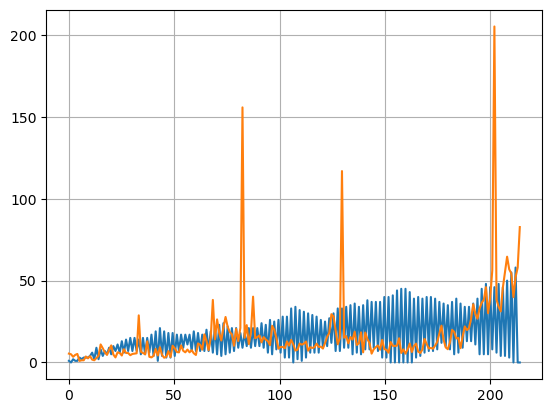

In [29]:
plt.plot(np.linspace(0, 214, 214), central_high_v1['I_High + I_Low'][12], label = 'I_High + I_Low')
plt.plot(np.linspace(0, 214, 214), central_daily_total[:214], label = 'Diff')
plt.grid()

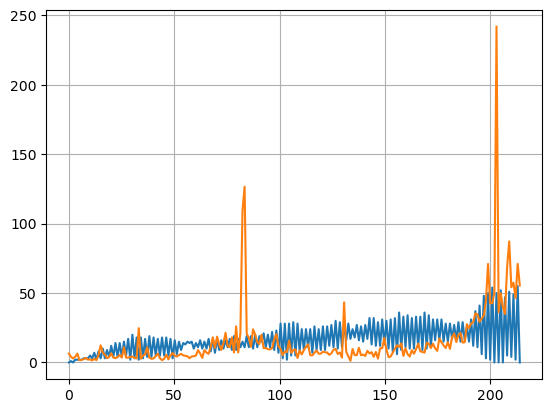

In [30]:
plt.plot(np.linspace(0, 214, 214), east_high_v1['I_High + I_Low'][12], label = 'I_High + I_Low')
plt.plot(np.linspace(0, 214, 214), east_daily_total[:214], label = 'Diff')
plt.grid()

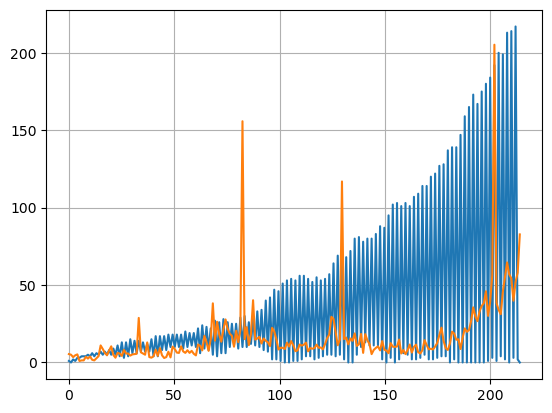

In [28]:
# plt.plot(np.linspace(0, 214, 214), central_high_v1['I_High + I_Low'][8], label = 'I_High + I_Low')
# plt.plot(np.linspace(0, 214, 214), central_daily_total[:214], label = 'Diff')
# plt.grid()